# LBH to Electron Total Energy Flux Model Training

This was my attempt at applying neural network modeling to predicting electron total energy flux from LBHL and LBHS emission data using only 1 week of data. Because of the small amount of data, I omitted k cross fold validation and a bunch of necessary steps that would make this a big data problem. 

In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print(devices)

import numpy as np
import h5py 
import os
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from collections import defaultdict
from PIL import Image
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
import glob
import pdb
from scipy.ndimage import uniform_filter1d
import pickle
import xlwt 
from xlwt import Workbook 
import csv

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Get the Conjunction data

In [2]:
# hd_dir = os.path.join('/home/matsuo/amgeo_dev/Pseudo_ML','conjunction_data2')
hd_dir = os.path.join('/Volumes/Sandisk500/AMGeO/DMSP LEO/','conjunction_data/F1718-SSUSIv3') # PATH TO DATA FOLDER
file_dir = os.path.join(hd_dir,'*.hdf5')
conjunc_files = glob.glob(file_dir)
conjunc_files = np.sort(conjunc_files) #sort the files by time 

# ele_diff_energy_flux_arr,ion_diff_energy_flux_arr = np.empty((0,19)) ,np.empty((0,19))
ele_flux, ion_flux = [],[]
ssusi_lbhl, ssusi_lbhs = [],[]
ssusi_solar_irr, ssusi_aurora = [], [] # new features
jds, lons, lats = [], [], []
sat_nums, passes = [], []

ssj_lbhl, ssj_lbhs = [],[]
# print(conjunc_files)

for file_name in conjunc_files:
    with h5py.File(file_name, 'r') as f:

        jds.extend(f['jds'][:])
        passes.extend(f['pass_num'][:])
        sat_nums.extend(f['sat_no'][:])
        lons.extend(f['lons'][:])
        lats.extend(f['lats'][:])
        
        #input data
        ssusi_lbhl.extend(f['LBHL_interped'][:])
        ssusi_lbhs.extend(f['LBHS_interped'][:])
        ssusi_solar_irr.extend(f['solar_irr_mask_interped'][:])
        ssusi_aurora.extend(f['aurora_mask_interped'][:])
        #output 
        # ele_diff_energy_flux_arr = np.vstack((ele_diff_energy_flux_arr, f['ele_diff_energy_flux'][:]))
        # ion_diff_energy_flux_arr = np.vstack((ion_diff_energy_flux_arr, f['ion_diff_energy_flux'][:]))
        ele_flux.extend(f['ele_total_energy_flux'][:])
        ion_flux.extend(f['ion_total_energy_flux'][:])
    

In [3]:
#convert to numpy arrays 
ele_flux, ion_flux = np.asarray(ele_flux), np.asarray(ion_flux)
ssusi_lbhl, ssusi_lbhs = np.asarray(ssusi_lbhl), np.asarray(ssusi_lbhs)
ssusi_solar_irr, ssusi_aurora = np.array(ssusi_solar_irr), np.array(ssusi_aurora)
jds = np.asarray(jds)
sat_nums, passes = np.asarray(sat_nums), np.asarray(passes)
lons, lats = np.asarray(lons), np.asarray(lats)
# ssj_lbhl, ssj_lbhs = np.asarray(ssj_lbhl), np.asarray(ssj_lbhs)

print(ssusi_solar_irr.shape)
print(ssusi_aurora.shape)
print(ssusi_lbhs.shape)

(541152,)
(541152,)
(541152,)


## Feature Engineering

### Format the data and get rid of invalid data

In [4]:
ssusi_lbhl_mask = np.isfinite(ssusi_lbhl)
ssusi_lbhs_mask = np.isfinite(ssusi_lbhs)
ssusi_solar_irr_mask = np.isfinite(ssusi_solar_irr)
ssusi_aurora_mask = np.isfinite(ssusi_aurora)
ele_flux_mask = np.isfinite(ele_flux)
ion_flux_mask = np.isfinite(ion_flux)

mask_big = np.logical_and.reduce([ssusi_lbhl_mask, ssusi_lbhs_mask, ele_flux_mask,ion_flux_mask, ssusi_solar_irr_mask,ssusi_aurora_mask]).flatten()

In [5]:
#apply the masks
# ele_diff_energy_flux_arr = ele_diff_energy_flux_arr[mask_big]
lons, lats = lons[mask_big], lats[mask_big]
# ssj_lbhl, ssj_lbhs = ssj_lbhl[mask_big], ssj_lbhs[mask_big]
ele_flux, ion_flux, ssusi_lbhl, ssusi_lbhs, jds, sat_nums, passes,ssusi_solar_irr,ssusi_aurora = ele_flux[mask_big], ion_flux[mask_big], ssusi_lbhl[mask_big], ssusi_lbhs[mask_big], jds[mask_big], sat_nums[mask_big], passes[mask_big],ssusi_solar_irr[mask_big],ssusi_aurora[mask_big]

### Concatenate ML features

In [8]:
ssusi_lbhl = ssusi_lbhl.reshape(-1,1)
ssusi_lbhs = ssusi_lbhs.reshape(-1,1)
X = np.hstack(( ssusi_lbhl ,  ssusi_lbhs, np.divide(ssusi_lbhs,ssusi_lbhl,out=np.zeros_like(ssusi_lbhs),where=ssusi_lbhl!=0), ssusi_solar_irr.reshape(-1,1), ssusi_aurora.reshape(-1,1)  ))
print('X=\n')
print(X)
print(X.shape)

X=

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 ...
 [0.47439343 0.17320273 0.36510357 1.         0.21422714]
 [0.47453419 0.17322983 0.36505237 1.         0.21387627]
 [0.47466    0.17325314 0.36500472 1.         0.21354069]]
(541130, 5)


In [9]:
y = ele_flux.reshape(-1,1) / (1.6e-12 * np.pi) # convert from erg to eV/ (cm2 * ster * S)
print('y=')
print(y)
print(y.shape)

y=
[[9.7918776e+19]
 [6.1276830e+19]
 [9.6042552e+19]
 ...
 [1.2307735e+22]
 [1.2691639e+22]
 [1.5446076e+22]]
(541130, 1)


### Scale the Features

Use robustscaler since the data isn't quite Gaussian enough to use standard scaler

In [10]:
scaler_y = RobustScaler()
scaler_x = RobustScaler()

scaler_x.fit(X)
scaler_y.fit(y)

X = scaler_x.transform(X)
y = scaler_y.transform(y)

Save the scalers 

In [11]:
#save the scalers for later analysis
pickle.dump(scaler_x, open('X_scaler3.pkl','wb'))
pickle.dump(scaler_y, open('Y_scaler3.pkl','wb'))

Save all of the Model Inputs

In [12]:
h5f = h5py.File('model3_inputs.h5','w')
h5f.create_dataset('X',data = X)
h5f.create_dataset('y',data = y)
h5f.create_dataset('ele_flux',data = ele_flux)
# h5f.create_dataset('ion_flux_smoothed',data = ion_flux_smoothed)
# h5f.create_dataset('ele_flux_smoothed',data = ele_flux_smoothed)
h5f.create_dataset('ion_flux',data = ion_flux)
h5f.create_dataset('ssusi_lbhl', data = ssusi_lbhl.flatten())
h5f.create_dataset('ssusi_lbhs', data = ssusi_lbhs.flatten())
h5f.create_dataset('ssusi_solar_irr', data = ssusi_solar_irr)
h5f.create_dataset('ssusi_aurora', data = ssusi_aurora)
h5f.create_dataset('sat_nums', data = sat_nums)
h5f.create_dataset('passes', data = passes)
h5f.create_dataset('jds', data = jds)
h5f.create_dataset('lons', data = lons)
h5f.create_dataset('lats', data = lats)
# h5f.create_dataset('ele_diff_energy_flux_arr', data = ele_diff_energy_flux_arr)
h5f.close()

# Neural Network Training

Really the only thing of note with this model is the usage of leakyReLu. I choice that activation function because I really wanted to enforce nonzero neuron activation and as a result enforce non linearity. 

In [263]:
def get_model(n_inputs,n_outputs):
    """
    Super Simple sequential neural network model
    """
    NN_model = keras.Sequential()

    # The Input Layer :
    NN_model.add(keras.layers.Dense(16, kernel_initializer='normal',input_dim = n_inputs, activation='LeakyReLU'))
    
    # The Hidden Layers :
    # hidden_layer = tf.keras.layers.LeakyReLU(32 ) 
    # NN_model.add(hidden_layer)
    # TOGGLED HIDDEN LAYER
    NN_model.add(keras.layers.Dense(24, kernel_initializer='normal',activation='LeakyReLU') )


    # The Output Layer :
    NN_model.add(keras.layers.Dense(n_outputs, kernel_initializer='normal',activation='linear') )
    
    opt = keras.optimizers.Adadelta(learning_rate=0.01)
    
    # Compile the network :
    NN_model.compile(loss='msle', optimizer= opt, metrics=['mse','msle','mean_absolute_percentage_error'])

    return NN_model

## Test Train split 

Here I wanted to kep track of which passes were test and which weren't. If that's not important ignore the hardcoding here.

In [264]:
unique_passes = np.unique(passes)
len(unique_passes)

383

In [265]:
# let 10% of passes be test passes
test_ratio = 0.1 
num_test_passes = int(test_ratio * len(unique_passes) ) - 1

#pick random passes to be test passes
index = np.random.choice(unique_passes, num_test_passes, replace=False) 
test_pass_nums = [ 12.,  18.,  22.,  35.,  51.,  70.,  72.,  83.,  88.,  91., 112.,
       113., 135., 137., 150., 158., 161., 168., 184., 189., 205., 208.,
       216., 217., 222., 228., 240., 244., 261., 263., 267., 272., 274.,
       275., 277., 285., 306., 316., 318., 323., 337., 348., 359., 372.,
       387., 395., 416., 420., 428., 436., 466., 481., 513., 520., 538.,
       555., 566.]
test_mask = np.zeros_like(passes, dtype = bool)
for pass_ind in test_pass_nums:
    test_mask = np.logical_or(test_mask, passes == pass_ind)
train_mask = np.logical_not(test_mask)

In [266]:
y_test, y_train = y[test_mask], y[train_mask]
X_test, X_train = X[test_mask], X[train_mask]
jd_test = jds[test_mask] 
# ssj_lbhl_test, ssj_lbhs_test = ssj_lbhl[test_mask] , ssj_lbhs[test_mask] 
sat_nums_test = sat_nums[test_mask]
#add lat lon

print(y_test.shape)
print(y_train.shape)

(62168, 1)
(478962, 1)


## Fit the model 

In [267]:
#get training data
index = np.random.choice(np.arange(len(X_train)), int(test_ratio * len(X_train) ), replace=False)  
X_train_percent = X_train[index]
y_train_percent = y_train[index]
#train the nn
model = get_model(5,1)

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 16)                96        
                                                                 
 dense_71 (Dense)            (None, 24)                408       
                                                                 
 dense_72 (Dense)            (None, 1)                 25        
                                                                 
Total params: 529 (2.07 KB)
Trainable params: 529 (2.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [268]:
#this callbackwill stop the training when there is no improvement in validation loss for 5 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3,restore_best_weights = True,start_from_epoch=15)
# callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 40,restore_best_weights = True)

stats = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks = [callback])

Epoch 1/20


2023-12-12 17:10:05.834715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11975/11975 [==============================] - ETA: 0s - loss: 0.5635 - mse: 93.1978 - msle: 0.5635 - mean_absolute_percentage_error: 2396.3547

2023-12-12 17:11:18.886283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11975/11975 [==============================] - 82s 7ms/step - loss: 0.5635 - mse: 93.1978 - msle: 0.5635 - mean_absolute_percentage_error: 2396.3547 - val_loss: 0.5669 - val_mse: 171.8974 - val_msle: 0.5669 - val_mean_absolute_percentage_error: 4995.9067
Epoch 2/20
11975/11975 [==============================] - 82s 7ms/step - loss: 0.3928 - mse: 81.7607 - msle: 0.3928 - mean_absolute_percentage_error: 3246.2302 - val_loss: 0.5190 - val_mse: 156.0665 - val_msle: 0.5190 - val_mean_absolute_percentage_error: 4859.3242
Epoch 3/20
11975/11975 [==============================] - 79s 7ms/step - loss: 0.3825 - mse: 75.5725 - msle: 0.3825 - mean_absolute_percentage_error: 3195.7109 - val_loss: 0.5057 - val_mse: 151.0689 - val_msle: 0.5057 - val_mean_absolute_percentage_error: 4926.4751
Epoch 4/20
11975/11975 [==============================] - 87s 7ms/step - loss: 0.3778 - mse: 73.9729 - msle: 0.3778 - mean_absolute_percentage_error: 3190.7544 - val_loss: 0.4974 - val_mse: 147.9155 - val_msle: 0.

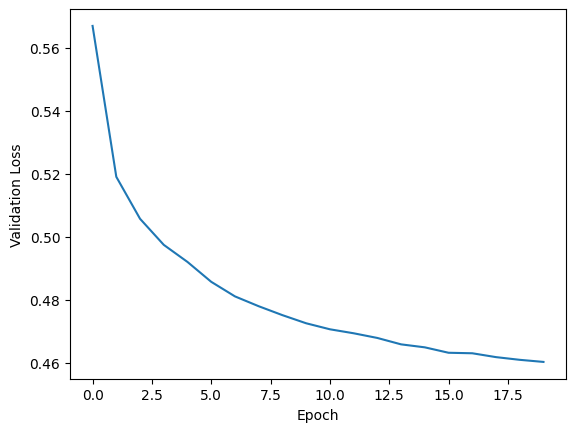

In [269]:
plt.plot(stats.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss');

In [270]:


with open('./CSCI5922 Project - Trials.csv', 'a') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile) 

    csvwriter.writerow([stats.history['loss'][-1], stats.history['val_loss'][-1], stats.history['val_mean_absolute_percentage_error'][-1], len(stats.history['loss'])])

    csvfile.close()

loss_epochs = np.copy(stats.history['val_loss'])
for i in range(len(stats.history['val_loss']),30):
    loss_epochs = np.append(loss_epochs,-999)

print(loss_epochs)

with open('./CSCI5922 Project - Loss Epochs.csv', 'a') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile) 

    csvwriter.writerow(loss_epochs)

    csvfile.close()

[ 5.66889644e-01  5.18975198e-01  5.05650818e-01  4.97371882e-01
  4.91939902e-01  4.85632002e-01  4.81005132e-01  4.77882087e-01
  4.75049824e-01  4.72470194e-01  4.70562279e-01  4.69296843e-01
  4.67807978e-01  4.65774983e-01  4.64827865e-01  4.63106990e-01
  4.62946564e-01  4.61720586e-01  4.60864693e-01  4.60198671e-01
 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02 -9.99000000e+02
 -9.99000000e+02 -9.99000000e+02]


In [271]:
# arr = np.loadtxt("./CSCI5922 Project - Loss Epochs.csv",
#                  delimiter=",", dtype=float)

# print(arr)

### Save the model

In [272]:
# model.save('lbh_ion_mask_to_ele_flux_v3')